In [5]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install contextily


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install pyproj

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import geopandas as gp
import shapely
from shapely.geometry import shape
from shapely.geometry import Point
import requests
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
import json
import time

In [33]:
#Lädt ein Track über die TrackId als GeoDataFrame
#@return das Geodataframe
def loadTrack(trackId) -> gp.GeoDataFrame:
    track = 'https://envirocar.org/api/stable/tracks/' + trackId
    myCarTrack = gp.read_file(track)
    tmp_list = []
    for x in range(0,myCarTrack.shape[0],4):
        tmp_list.append({
        'id': myCarTrack.loc[x,'id'],
        'time': myCarTrack.loc[x,'time'],
        'phenomenons': myCarTrack.loc[x,'phenomenons'],
        'geometry': myCarTrack.loc[x,'geometry']
        })
    subCarTrack = gp.GeoDataFrame(tmp_list)
    return subCarTrack

#Lädt die BBox von den übergebenen Trackpunkten
#@return BBox als Array (minX, minY, maxX, maxY)
def getBounds(subCarTrack) -> np.array:
    minMaxCoords = subCarTrack.total_bounds
    return minMaxCoords

#Lädt die OSM Straßen in der übergebenen BBox plus einem Puffer mit der übergebenen Radiusgröße
#@return OSM Straßen in BBox als Geodataframe
def getStreets(minMaxCoords, radius) -> gp.GeoDataFrame:
    streets = 'https://overpass-api.de/api/interpreter?data=[out%3Ajson][timeout%3A25]%3B%0A(%0A%20%20way["highway"~"^(motorway|trunk|primary|residential|tertiary|motorway_link|unclassified|service|secondary|secondary_link|trunk|trunk_link)%24"]'+\
    '('+str(minMaxCoords[1]-radius) + '%2C'+str(minMaxCoords[0]-radius) + '%2C'+str(minMaxCoords[3]+radius) + '%2C'+str(minMaxCoords[2]+radius)+')%3B%0A)%3B%0Aout%20geom%3B'
    response = requests.get(streets)
    mystreets = response.json()['elements']
    for d in mystreets:
        coords = []
        for p in d['geometry']:
            coords.append((p['lon'],p['lat']))
        data = {"type": "LineString", "coordinates": coords}
        d['geometry'] = shape(data)
    gdfStreets = gp.GeoDataFrame(mystreets).set_geometry('geometry')
    return gdfStreets

#Erzeugt einen Puffer um übergebene Trackpunkte mit übergebener Radiusgröße
#@return pufferpolygone als Geodataframe
def getBuffer(subCarTrack, radius) ->gp.GeoDataFrame:
    buffer = subCarTrack.buffer(radius) #0.0002 = 20m??
    buffergdf = gp.GeoDataFrame(geometry=buffer)
    buffergdf.insert(0, "Id", range(1,1+len(buffergdf)))
    return buffergdf

#Sammle alle Straßen die in den übergebenen Puffern liegen
#@return Straßen die in dem übergebenem Puffer liegen als GDF
def getIntersectingStreets(gdfStreets, buffergdf) -> gp.GeoDataFrame:
    intersectingStreets = gp.GeoDataFrame()
    for buff in buffergdf.iterrows():
        tempStreets = []
        tempStreets = gp.overlay(gdfStreets, gp.GeoDataFrame(geometry=[buff[1]['geometry']]), how='intersection')
        tempStreets['pufferId'] = buff[1]['Id']
        intersectingStreets = pd.concat([intersectingStreets,tempStreets])
    return intersectingStreets

#Erzeugt alle am nächsten liegenden Punkte zu den Ursprungspunkten im angegebenen Polygon
#@return alle gesnappten Punkte als GDF
def getSnappedPoints(intersectingStreets, subCarTrack) -> gp.GeoDataFrame:
    snappedPoints = []
    i=0
    for index, row in intersectingStreets.iterrows():
        activePoint = subCarTrack.loc[row['pufferId']-1]
        snappedPoints.append({
            'id': i,
            'pufferId': row['pufferId'],
            'pointId': activePoint['id'],
            'geometry': row['geometry'].interpolate(row['geometry'].project(activePoint.geometry))
        })
        i = i+1
    snappedPointsGdf = gp.GeoDataFrame(snappedPoints)
    return snappedPointsGdf

#Lädt die Koordinaten der gesnappten Punkte in ein neues GDF
#@return die Koordinaten der gesnapptne Punkte als dict
def getCoordinatesOfSnappedPts(snappedPointsGdf) -> dict:
    coordinatesSnappedPts = {}
    for index, row in snappedPointsGdf.iterrows():
        coordinatesSnappedPts[row['id']] = (row['geometry'].x, row['geometry'].y)
    return coordinatesSnappedPts

#Erzeugt den Knotengraph aus den gesnappten Punkten
#@return der Knotengraph als dict
def getGraphOfSnappedPts(snappedPointsGdf, buffergdf) -> dict:
    snappedPtsGraph = {}
    lastIndex = -1
    for index, buffrow in buffergdf.iterrows():
        if lastIndex != -1: #nicht erste iteration
            tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == buffrow['Id']]
            for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
                snappedPtsGraph[firstCol['id']] = list(tempPoints['id'])
        lastIndex = buffrow['Id']
    return snappedPtsGraph

def getDistances(sourcePs, destPs, metrics = "duration"):
    # bei "duration" antwort in Sekunden
    # dei "distance" antwort in Metern
    url = "https://ors5.fbg-hsbo.de//v2/matrix/driving-car"
    N = len(sourcePs)
    M = len(destPs)
    locationsP = sourcePs + destPs
    body = {"locations":locationsP, "destinations":list(range(N,N+M)), "sources":list(range(0,N)), "metrics":[metrics]}
    # spalten nach destinations, zeile nach sources
    headers = {'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf6248313acae367214955a3dcb710c5e4e0b8',
    'Content-Type': 'application/json; charset=utf-8'}
    call = requests.post(url, json=body)
    edgeValues = json.loads(call.text)[metrics+"s"]
    return edgeValues

def createForks(sourcePIDs, destPIDs, distMatrix):
    retDict = {}
    for sPID in sourcePIDs:
        retDict[sPID] = {}
    for j in range(0, len(sourcePIDs)):
        sourcePID = sourcePIDs[j]
        for i in range(0, len(destPIDs)):
            #print(i)
            retDict[sourcePID][destPIDs[i]] = distMatrix[j][i]
    return retDict

def createProbGraph(coordinatesSnappedPts, snappedPtsGraph, metrics = "duration"):
    pDict = coordinatesSnappedPts
    forkDict = snappedPtsGraph
    #Kantenwerte als Wahrscheinlichkeioten...
    routingGraph = {}
    for sourcePID, destPIDList in forkDict.items():
        tempDestPDict = {}
        for destPID in destPIDList:
            tempDestPDict[destPID] = pDict[destPID]
            pDict[sourcePID]
            distances = getDistances([pDict[sourcePID]],list(tempDestPDict.values()), metrics = metrics)
            total = sum(distances[0])                         
            ws = []
            for value in distances[0]:
                ws.append(value/total)
            routingGraph.update(createForks([sourcePID],list(tempDestPDict.keys()),[ws]))
            #time.sleep(10)
    return routingGraph

#Erzeugt den KnotenGraphen mit den erreichneten Distanzen/wahrscheinlichkeiten (Distanz im Puffer * Routingdistanz zw Punkten)
#@return knotengraph mit den verrechneten Wahrscheinlichkeiten als dict
def createDistanceGraph(snappedPointsGdf, buffergdf, subCarTrack, routingGraph) -> dict:
    distanceGraph = {}
    distanceGraph[-1] = {}
    for index, node in snappedPointsGdf.iterrows():
        distanceGraph[node['id']] = {}
    lastIndex = -1
    for index, buffrow in buffergdf.iterrows():
        tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == buffrow['Id']]
        summe = 0
        for index, tp1 in tempPoints.iterrows():
            actSnappedPoint = (tp1['geometry'].x, tp1['geometry'].y)
            actBasePoint = (subCarTrack['geometry'].iloc[buffrow['Id']-1].x, subCarTrack['geometry'].iloc[buffrow['Id']-1].y)
            abstand = distance.euclidean(actSnappedPoint, actBasePoint)
            summe = summe + abstand
        #erste Iteration
        if lastIndex == -1:
            for index, tp in tempPoints.iterrows():
                actSnappedPoint = (tp['geometry'].x, tp['geometry'].y)
                actBasePoint = (subCarTrack['geometry'].iloc[buffrow['Id']-1].x, subCarTrack['geometry'].iloc[buffrow['Id']-1].y)
                abstand = distance.euclidean(actSnappedPoint, actBasePoint)
                distanceGraph[-1][tp['id']] = (abstand/summe)
        else: #nicht erste iteration
            for i, secondCol in tempPoints.iterrows():
                for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
                    actBasePoint = (subCarTrack['geometry'].iloc[buffrow['Id']-1].x, subCarTrack['geometry'].iloc[buffrow['Id']-1].y)
                    secColPoint = (secondCol['geometry'].x, secondCol['geometry'].y)
                    abstand = distance.euclidean(actBasePoint, secColPoint)
                    distanceGraph[firstCol['id']][secondCol['id']] = ((abstand/summe)) * routingGraph[firstCol['id']][secondCol['id']]
        lastIndex = buffrow['Id']
    for index, pts in snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == buffergdf['Id'].max()].iterrows():
        distanceGraph[pts['id']][-2] = 0
    return distanceGraph

#Findet den kürzesten Weg mittels Dijkstra algorithmus
#Anleitung: https://www.happycoders.eu/de/algorithmen/dijkstra-algorithmus-java/
#@return Tabelle mit allen knoten inklusive Vorgänger und Gesamtdistanz als Dataframe
def dijkstra(distanceGraph) -> pd.DataFrame:
    unbesuchteKnoten = list(distanceGraph)
    unbesuchteKnoten.append(-2)
    dijkstraTable = pd.DataFrame(unbesuchteKnoten, columns=['Knoten'])
    dijkstraTable['Vorgaenger'] = -99
    dijkstraTable['Gesamtdistanz'] = float('inf')
    startID = -1
    endID = -2

    dijkstraTable.loc[dijkstraTable['Knoten'] == -1,'Gesamtdistanz'] = 0
    for nachbarn in distanceGraph[startID].items():
        dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Gesamtdistanz'] = nachbarn[1]
        dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Vorgaenger'] = -1
    unbesuchteKnoten.remove(-1)
    while (len(unbesuchteKnoten) != 0 and (-2 in unbesuchteKnoten)):
        tempTabelle = dijkstraTable[dijkstraTable['Vorgaenger'] != -99]
        tempTabelle.sort_values(by=['Gesamtdistanz'], inplace=True)
        i =0
        while(tempTabelle.iloc[i]['Knoten'] not in unbesuchteKnoten):
            i = i+1
        activePoint = tempTabelle.iloc[i]
        if (activePoint['Knoten'] != -2):
            for nachbarn in distanceGraph[activePoint['Knoten']].items():
                if nachbarn[0] in unbesuchteKnoten:
                    if ((activePoint['Gesamtdistanz']+nachbarn[1]) < dijkstraTable[dijkstraTable['Knoten'] == nachbarn[0]]['Gesamtdistanz']).bool():
                        dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Gesamtdistanz'] = activePoint['Gesamtdistanz']+nachbarn[1]
                        dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Vorgaenger'] = activePoint['Knoten']
                dijkstraTable
        unbesuchteKnoten.remove(activePoint['Knoten'])
    return dijkstraTable

#Holt die Ids zu den Knoten die durch den Dijkstra im kürzesten Weg benutzt werden
#@return Ids als int-List
def getDriveWayIds(dijkstraTable) -> list[int]:
    driveWayIds = [-2]
    while ((dijkstraTable[dijkstraTable["Knoten"] == driveWayIds[-1]]["Vorgaenger"]).item() != -99):
        driveWayIds.append(dijkstraTable[dijkstraTable["Knoten"] == driveWayIds[-1]]["Vorgaenger"].item())
    driveWayIds.reverse()
    driveWayIds.remove(-1)
    driveWayIds.remove(-2)
    return driveWayIds

#Holt die Koordinaten zu den Knoten die durch den Dijkstra im kürzesten Weg benutzt werden
#@return Coords als list[x,y]
def getDriveWayCoords(dijkstraTable, coordinatesSnappedPts) -> list:
    driveWayCoords = []
    for id in getDriveWayIds(dijkstraTable):
        driveWayCoords.append([coordinatesSnappedPts[id][0], coordinatesSnappedPts[id][1]])
    return driveWayCoords

def getDriveWayPts(dijkstraTable, coordinatesSnappedPts):
    driveWayPts = []
    for row in getDriveWayIds(dijkstraTable):
        driveWayPts.append({
            'id': row,
            'geometry': Point(coordinatesSnappedPts[row][0], coordinatesSnappedPts[row][1])
        })
    driveWayPtsGDF = gp.GeoDataFrame(driveWayPts)
    return driveWayPtsGDF

#Holt die wahrscheinlichste gefahrene Route zu den übergebenen Punkten
#@return die gefahrene Linie als GDF
def getDriveWay(dijkstraTable, coordinatesSnappedPts) -> gp.GeoDataFrame:
    body = {"coordinates":getDriveWayCoords(dijkstraTable, coordinatesSnappedPts)}
    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': '5b3ce3597851110001cf624837b0be5d89604065b03e13c82ba84c06',
        'Content-Type': 'application/json; charset=utf-8'
    }
    call = requests.post('https://api.openrouteservice.org/v2/directions/driving-car/geojson', json=body, headers=headers)
    driveWayLine = json.loads(call.text)["features"][0]["geometry"]
    geom = [shape(i) for i in [driveWayLine]]
    driveWayGDF = gp.GeoDataFrame({'geometry':geom})
    return driveWayGDF

C:\Users\Admin\AppData\Local\Temp\ipykernel_13048\2304495646.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempTabelle.sort_values(by=['Gesamtdistanz'], inplace=True)


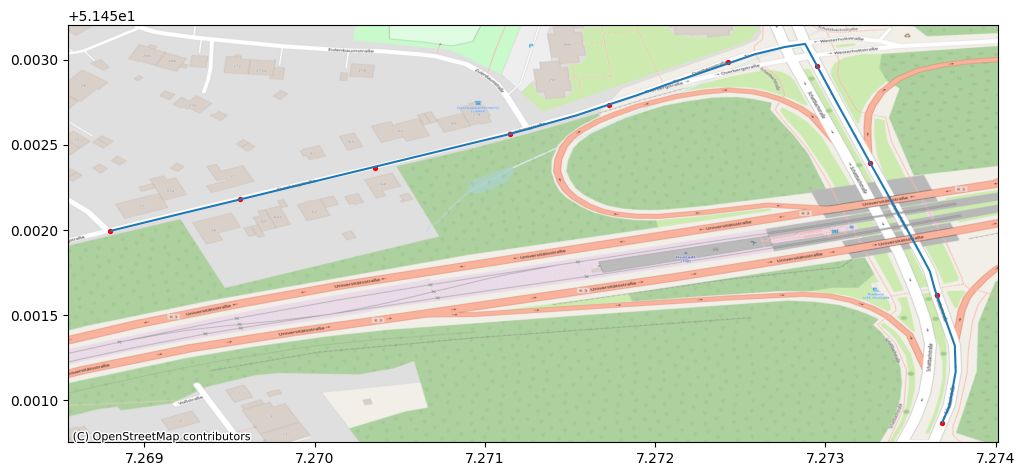

In [35]:
trackId = '63948bc3ad53a0015a08780f'
radius = 0.0002

subCarTrack = loadTrack(trackId)
minMaxCoords = getBounds(subCarTrack)
gdfStreets = getStreets(minMaxCoords, radius)
buffergdf = getBuffer(subCarTrack, radius)
intersectingStreets = getIntersectingStreets(gdfStreets, buffergdf)
snappedPointsGdf = getSnappedPoints(intersectingStreets, subCarTrack)

#fig, ax = plt.subplots()
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#plt.ylim((51.450,51.4535))
#plt.xlim((7.268,7.2745))
##worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
#buffergdf.plot(ax=ax, color='yellow', alpha=0.4)
#gdfStreets.plot(ax=ax, alpha=0.8)
#snappedPointsGdf.plot(ax=ax, color='red', markersize=6, zorder=3)
#subCarTrack.plot(ax=ax, color='black', markersize=8, zorder=3)
#cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

coordinatesSnappedPts = getCoordinatesOfSnappedPts(snappedPointsGdf)
snappedPtsGraph = getGraphOfSnappedPts(snappedPointsGdf, buffergdf)
routingGraph = createProbGraph(coordinatesSnappedPts, snappedPtsGraph)
distanceGraph = createDistanceGraph(snappedPointsGdf, buffergdf, subCarTrack, routingGraph)
dijkstraTable = dijkstra(distanceGraph)
driveWayPtsGDF = getDriveWayPts(dijkstraTable, coordinatesSnappedPts)
driveWayGDF = getDriveWay(dijkstraTable, coordinatesSnappedPts)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = driveWayPtsGDF.plot(ax=driveWayGDF.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)